# Import packages

In [1]:
import numpy as np
import altair as alt
import pandas as pd
import geopandas as gpd
from datetime import timedelta
from scipy import stats
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt

from helper_functions import open_delays

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'

DISTRIBUTION = stats.exponnorm
DISTRIBUTION_NAME = 'exponnorm'

# Load data

In [3]:
delays = open_delays(DELAYS_FILEPATH)
delays.head(3)

Amount of delay values: 3_802_649


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0,6.0
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0,6.0
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0,7.0


# Find related values

In [4]:
# Find related values next stop same train
delays_sorted = delays.sort_values(by=['trip_id', 'sched_arrival_time']).copy()

stop_values = delays_sorted['stop'].values
delay_values = delays_sorted['delay'].values
trip_ids = delays_sorted['trip_id'].values
sched_arrivals = delays_sorted['sched_arrival_time'].values
real_arrivals = delays_sorted['real_arrival_time'].values
timesteps = delays_sorted['timestep'].values

related_forward = pd.DataFrame({'line': delays_sorted['line_name'].values,
                               'stop': stop_values,
                               'prev_stop': [stop_values[-1], *stop_values[:-1]],
                               'next_stop': [*stop_values[1:], stop_values[0]],
                               'delay': delay_values,
                               'delay_prev_stop': [delay_values[-1], *delay_values[:-1]],
                               'trip_id': trip_ids,
                               'sched_arrival': sched_arrivals,
                               'real_arrival': real_arrivals,
                               'timestep': timesteps,
                               'prev_trip_id': [trip_ids[-1], *trip_ids[:-1]],
                               'next_trip_id': [*trip_ids[1:], trip_ids[0]]})

print(f"Total: {len(related_forward):_}")
related_forward = related_forward[(related_forward['trip_id'] == related_forward['prev_trip_id']) | (related_forward['trip_id'] == related_forward['next_trip_id'])]
related_forward.loc[related_forward['trip_id'] != related_forward['prev_trip_id'], ['prev_stop', 'delay_prev_stop']] = None
related_forward = related_forward.drop(columns=['trip_id', 'next_trip_id', 'prev_trip_id'])

print(f"Filtered to only viable: {len(related_forward):_}")
related_forward.head(3)

Total: 3_802_649
Filtered to only viable: 3_802_596


,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,timestep
0,SILVER,G05,None,G04,-569.0,NaN,2019-10-14 13:08:00,2019-10-14 12:58:31,13.0
1,SILVER,G04,G05,G03,-88.0,-569.0,2019-10-14 13:11:00,2019-10-14 13:09:32,13.0
2,SILVER,G03,G04,G02,-106.0,-88.0,2019-10-14 13:14:00,2019-10-14 13:12:14,13.0


In [5]:
# Find related values for next train same stop
related_forward = related_forward.sort_values(by=['sched_arrival']).copy()
station_split = {trip_key: data for trip_key, data in related_forward.groupby(['stop', 'next_stop'])}

updated_dfs = []
for key_pair, station_stops in station_split.items():

    station_stops['delay_ptss'] = [None, *station_stops['delay'][:-1]]
    station_stops['real_arrival_prev_train'] = [None, *station_stops['real_arrival'].values[:-1]]
    station_stops['sched_arrival_prev_train'] = [None, *station_stops['sched_arrival'].values[:-1]]

    updated_dfs.append(station_stops)

related_forward = pd.concat(updated_dfs)
print(len(related_forward))
related_forward.head(3)


3802596


C:\Users\lange\AppData\Local\Temp\ipykernel_17164\2121696514.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_forward = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_17164\2121696514.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_forward = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_17164\2121696514.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,7.0,NaN,NaT,NaT
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,7.0,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,7.0,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00


# Filter out inplace occurences

In [6]:
inplace_occcurences = related_forward[(related_forward['real_arrival_prev_train'] >= related_forward['sched_arrival']) & (related_forward['real_arrival'] > related_forward['real_arrival_prev_train'])].copy()
print(f"Amount of found inplace ocurrences: {len(inplace_occcurences):_}")

related_forward_assigned = related_forward[~related_forward.index.isin(inplace_occcurences.index)]
print(f"New amount of forwardly related delays: {len(related_forward_assigned):_}")
related_forward_assigned.head(3)


Amount of found inplace ocurrences: 79_169
New amount of forwardly related delays: 3_723_427


,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,7.0,NaN,NaT,NaT
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,7.0,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,7.0,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00


# Calculate time diff

In [7]:
related_forward_with_diff = related_forward_assigned.copy()
related_forward_with_diff['delay_diff'] = related_forward_with_diff['delay'] - related_forward_with_diff['delay_prev_stop']
related_forward_with_diff.head(3)

,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train,delay_diff
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,7.0,NaN,NaT,NaT,-44.0
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,7.0,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00,-42.0
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,7.0,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00,-29.0


# Fit distributions total

In [ ]:
data_connection_timestep_split = {connection_timestep: data for connection_timestep, data in related_forward_with_diff.groupby(['prev_stop', 'stop', 'timestep'])}

timestep_list = []
from_list = []
to_list = []
params_list = []
determination_coeff_list = []

NON_EXISTENT_CONNECTIONS = [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02')] # Both directions
END_OF_LINE_CONNECTIONS = [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')] # Both directions?

def filter_out_connections(stop_pair):
    if stop_pair in NON_EXISTENT_CONNECTIONS or (stop_pair[1], stop_pair[0]) in NON_EXISTENT_CONNECTIONS:
        return True
    if stop_pair in END_OF_LINE_CONNECTIONS or (stop_pair[1], stop_pair[0]) in END_OF_LINE_CONNECTIONS:
        return True
    return False

for connection_timestep, data in data_connection_timestep_split.items():
    print(connection_timestep)

    from_stop = connection_timestep[0]
    to_stop = connection_timestep[1]
    timestep = connection_timestep[2]

    if filter_out_connections((from_stop, to_stop)):
        continue

    dist_data_list = np.array([int(delay) for delay in data['delay_diff'].values])
    model_input = np.array([int(delay) for delay in data['delay_prev_stop'].values])
    observed = np.array([int(delay) for delay in data['delay'].values])

    if len(dist_data_list) > 40:

        timestep_list.append(timestep)
        to_list.append(to_stop)
        from_list.append(from_stop)

        dist_params = DISTRIBUTION.fit(dist_data_list)
        params_list.append(dist_params)

        mean = DISTRIBUTION.mean(*dist_params)
        model_prediction = model_input + mean

        sse = np.sum((observed - model_prediction) ** 2)
        sst = np.sum((observed - np.mean(observed)) ** 2)
        r_squared = 1 - (sse / sst)
        determination_coeff_list.append(r_squared)


        # Calculate Lack-of-fit sum of squares here
        


        if r_squared < 0:
            print("Warning: negative R^2 value encountered.")

forward_func_data = pd.DataFrame({'timestep': timestep_list,
                                    'from_stop': from_list,
                                    'to_stop': to_list,
                                    'dist_params': params_list,
                                    'coefficient of determination': determination_coeff_list})
forward_func_data.head(5)

('A01/C01', 'A02', np.float64(5.0))
('A01/C01', 'A02', np.float64(6.0))
('A01/C01', 'A02', np.float64(7.0))
('A01/C01', 'A02', np.float64(8.0))
('A01/C01', 'A02', np.float64(9.0))
('A01/C01', 'A02', np.float64(10.0))
('A01/C01', 'A02', np.float64(11.0))
('A01/C01', 'A02', np.float64(12.0))
('A01/C01', 'A02', np.float64(13.0))
('A01/C01', 'A02', np.float64(14.0))
('A01/C01', 'A02', np.float64(15.0))
('A01/C01', 'A02', np.float64(16.0))
('A01/C01', 'A02', np.float64(17.0))
('A01/C01', 'A02', np.float64(18.0))
('A01/C01', 'A02', np.float64(19.0))
('A01/C01', 'A02', np.float64(20.0))
('A01/C01', 'A02', np.float64(21.0))
('A01/C01', 'A02', np.float64(22.0))
('A01/C01', 'A03', np.float64(7.0))
('A01/C01', 'A03', np.float64(8.0))
('A01/C01', 'B01/F01', np.float64(5.0))
('A01/C01', 'B01/F01', np.float64(6.0))
('A01/C01', 'B01/F01', np.float64(7.0))
('A01/C01', 'B01/F01', np.float64(8.0))
('A01/C01', 'B01/F01', np.float64(9.0))
('A01/C01', 'B01/F01', np.float64(10.0))
('A01/C01', 'B01/F01', np.

KeyboardInterrupt: 

In [34]:
forward_func_data['dist_params'] = [[float(dist_param) for dist_param in dist_params] for dist_params in forward_func_data['dist_params'].values]

In [35]:
forward_func_data.to_csv(f"Second model results\\forward_total_{DISTRIBUTION_NAME}_goodness.csv")

In [36]:
forward_func_data['coefficient of determination'].describe()

count    2971.000000
mean        0.930549
std         0.085639
min        -0.195972
25%         0.913842
50%         0.958191
75%         0.978578
max         0.997937
Name: coefficient of determination, dtype: float64

<Axes: >

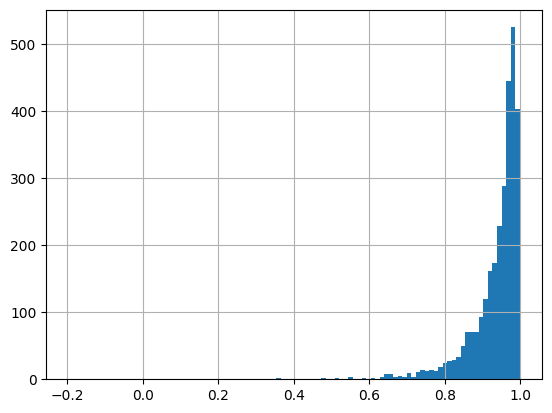

In [41]:
forward_func_data['coefficient of determination'].hist(bins=100)

In [37]:
forward_func_data['coefficient of determination'].median()

np.float64(0.9581906797516434)

{'whiskers': [<matplotlib.lines.Line2D at 0x22066666b40>,
 'caps': [<matplotlib.lines.Line2D at 0x220666667b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x220666672c0>],
 'medians': [<matplotlib.lines.Line2D at 0x220666660c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22066665a90>],
 'means': []}

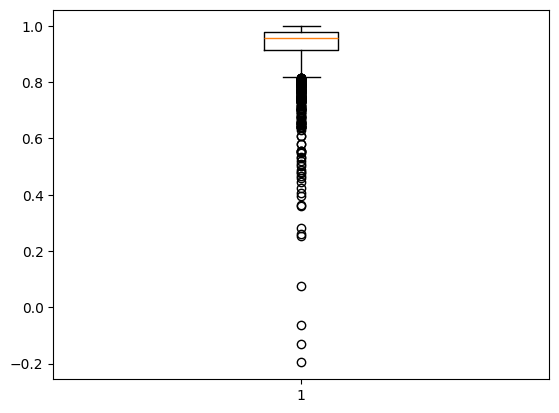

In [39]:
plt.boxplot(forward_func_data['coefficient of determination'])
# plt.ylim(0, 1)

# Fit distribution per weekday

In [13]:
related_forward_with_diff['weekday'] = [date.weekday() for date in related_forward_with_diff['sched_arrival']]
related_forward_with_diff.head(3)

,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train,delay_diff,weekday
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,7.0,NaN,NaT,NaT,-44.0,5
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,7.0,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00,-42.0,5
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,7.0,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00,-29.0,5


In [14]:
weekday_split = {weekday[0]: {connection_timestep: data for connection_timestep, data in weekday_data.groupby(['prev_stop', 'stop', 'timestep'])} for \
                 weekday, weekday_data in related_forward_with_diff.groupby(['weekday'])}
timesteps = related_forward_with_diff['timestep'].unique()
timesteps.sort()

for weekday, weekday_data in weekday_split.items():
    timestep_list = []
    from_list = []
    to_list = []
    params_list = []

    print(weekday)

    connection_set = set()
    for connection_timestep, data in weekday_data.items():

        from_stop = connection_timestep[0]
        to_stop = connection_timestep[1]
        timestep = connection_timestep[2]

        if (from_stop, to_stop) not in connection_set:
            print((from_stop, to_stop))
            connection_set.add((from_stop, to_stop))

        data_list = [int(delay) for delay in data['delay_diff'].values]

        if len(data_list) > 40:

            timestep_list.append(timestep)
            to_list.append(to_stop)
            from_list.append(from_stop)

            dist_params = DISTRIBUTION.fit(data_list)
            params_list.append(dist_params)

    forward_func_data = pd.DataFrame({'timestep': timestep_list,
                                        'from_stop': from_list,
                                        'to_stop': to_list,
                                        'dist_params': params_list})
    forward_func_data['dist_params'] = [[float(dist_param) for dist_param in dist_params] for dist_params in forward_func_data['dist_params'].values]
    forward_func_data.to_csv(f"Second model results\\forward_weekday_{weekday}_{DISTRIBUTION_NAME}.csv")

0
('A01/C01', 'A02')
('A01/C01', 'B01/F01')
('A01/C01', 'C02')
('A01/C01', 'D01')
('A01/C01', 'D02')
('A02', 'A01/C01')
('A02', 'A03')
('A03', 'A02')
('A03', 'A04')
('A03', 'A05')
('A04', 'A03')
('A04', 'A05')
('A04', 'A06')
('A05', 'A03')
('A05', 'A04')
('A05', 'A06')
('A06', 'A05')
('A06', 'A07')
('A06', 'A08')
('A07', 'A06')
('A07', 'A08')
('A08', 'A07')
('A08', 'A09')
('A09', 'A08')
('A09', 'A10')
('A10', 'A09')
('A10', 'A11')
('A11', 'A10')
('A11', 'A12')
('A12', 'A11')
('A12', 'A13')
('A12', 'A14')
('A13', 'A12')
('A13', 'A14')
('A14', 'A12')
('A14', 'A13')
('A14', 'A15')
('A15', 'A14')
('B01/F01', 'A01/C01')
('B01/F01', 'B02')
('B01/F01', 'E01')
('B01/F01', 'E02')
('B01/F01', 'F02')
('B02', 'B01/F01')
('B02', 'B03')
('B03', 'B02')
('B03', 'B35')
('B04', 'B05')
('B04', 'B35')
('B05', 'B04')
('B05', 'B06/E06')
('B06/E06', 'B05')
('B06/E06', 'B07')
('B06/E06', 'E05')
('B06/E06', 'E07')
('B07', 'B06/E06')
('B07', 'B08')
('B08', 'B07')
('B08', 'B09')
('B09', 'B08')
('B09', 'B10')
('B